In [3]:
using Colors
using Flux 
using Plots
using Statistics

In [4]:
function create_encoder(num_words::Int64, 
                        hidden_sizes::Vector{Int64}, 
                        word_sidelength::Int64)
    layers = []

    for h ∈ 0:length(hidden_sizes)
        if h == 0
            num_in  = num_words
            num_out = hidden_sizes[1]
            σ       = relu
        elseif h == length(hidden_sizes)
            num_in  = hidden_sizes[end]
            num_out = word_sidelength^2
            σ       = sigmoid
        else
            num_in  = hidden_sizes[h]
            num_out = hidden_sizes[h+1]
            σ       = relu
        end

        push!(layers, Dense(num_in, num_out, σ))
    end

    # This epsiode is brought to you by SquareShape
    square_shape = (word_sidelength, word_sidelength)

    # Add a final layer to shape it into a square, 4d for convolution
    push!(layers, x -> reshape(x, (square_shape..., 1, 1)))

    return Chain(layers...)
end

create_encoder (generic function with 1 method)

In [5]:
# function create_decoder(num_words::Int64, 
#                         hidden_sizes::Vector{Int64}, 
#                         word_sidelength::Int64)
#     layers = []

#     flat_shape = (word_sidelength^2, 1)

#     # Take the square to a flat layer
#     push!(layers, x -> reshape(x, flat_shape))

#     for h ∈ 0:length(hidden_sizes)
#         if h == length(hidden_sizes)
#             num_in  = hidden_sizes[end]
#             num_out = num_words
#             σ       = relu
#         elseif h == 0
#             num_in  = word_sidelength^2
#             num_out = hidden_sizes[1]
#             σ       = relu
#         else
#             num_in  = hidden_sizes[h]
#             num_out = hidden_sizes[h+1]
#             σ       = relu
#         end

#         push!(layers, Dense(num_in, num_out, σ; init=Flux.glorot_normal))
#     end

#     return Chain(layers...)
# end

In [31]:
function kernel_size_reduction(input, kernel, padding, stride)
    return ((input - kernel + 2 * padding) / stride) + 1
end

function maxpool_size_reduction(input, pool_size, stride)
    return ((input - pool_size) / stride) + 1
end

total_size_reduction = (y->maxpool_size_reduction(y, 2,2))∘(x->kernel_size_reduction(x, 3,1,1))

var"#47#49"() ∘ var"#48#50"()

In [22]:
composition(f, n) = ∘(ntuple(_ -> f, n)...)

composition (generic function with 1 method)

In [38]:
function create_decoder(num_words::Int64, 
                        hidden_sizes::Vector{Int64}, 
                        word_sidelength::Int64)	

    layers = [
        Conv((3, 3), 1=>16, pad=(1,1), relu),
        x -> maxpool(x, (2,2)),

        Conv((3, 3), 16=>32, pad=(1,1), relu),
        x -> maxpool(x, (2,2)),

        # Reshape 3d tensor into a 2d one, at this point it should be (3, 3, 32, N)
        # which is where we get the 288 in the `Dense` layer below:
        x -> flatten(x),
        Dense(288, num_words),

        # Finally, softmax to get nice probabilities
        softmax
    ]

    return Chain(layers...)

end

create_decoder (generic function with 1 method)

In [8]:
function word2vec(word::Int64)
    return Flux.onehot(word, 1:num_words)
end

word2vec (generic function with 1 method)

In [37]:
composition(total_size_reduction, 2)(12)

3.0

In [39]:
begin 
    num_words = 9
    word_sidelength = 12
    hidden_sizes    = [32, 64]

    init_speak  = create_encoder(num_words, hidden_sizes, word_sidelength)
    init_listen = create_decoder(num_words, reverse(hidden_sizes), word_sidelength)
end

Chain(Conv((3, 3), 1=>16, relu), #51, Conv((3, 3), 16=>32, relu), #52, #53, Dense(288, 9), softmax)

In [40]:
function visualise_speech(word::Array{Float32})
    if length(size(word)) > 2
        word = word[:,:,1,1]
    end

    matrix = Gray.(word)
    return plot(matrix, xaxis=nothing, yaxis=nothing)
end

visualise_speech (generic function with 1 method)

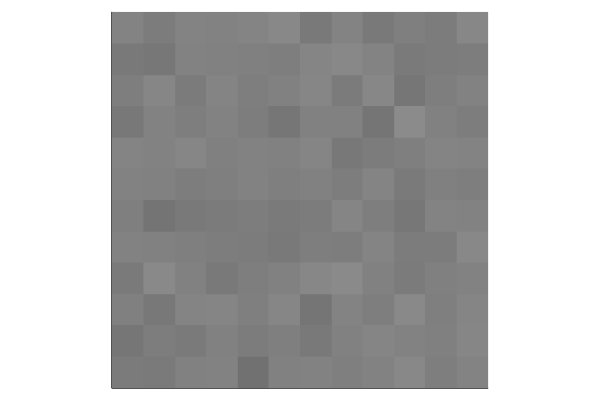

In [41]:
visualise_speech(init_speak(word2vec(1)))

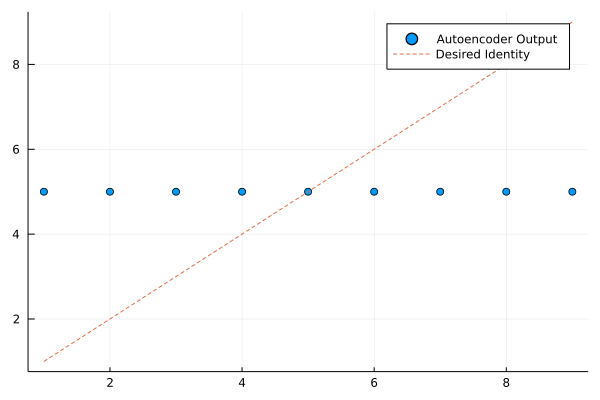

In [42]:
begin
    x = 1:num_words

    η =  argmax ∘ vec ∘ init_listen ∘ init_speak ∘ (x->word2vec(x))
    plot(x, η.(x), seriestype=:scatter, label="Autoencoder Output")
    plot!(x, x, ls=:dash, label="Desired Identity")
end

In [ ]:
speak  = deepcopy(init_speak)
listen = deepcopy(init_listen)
autoencoder = Chain(speak, listen)


loss(x,y) = Flux.Losses.crossentropy(autoencoder(x), y)

optimiser = ADAM()
θ = params(autoencoder)

iterations = 50
words   = [(a,b) for a in 1:num_words for b in 1:num_words]

losses = Float64[]
for _ in 1:iterations
    iteration_losses = []
    for i in 1:length(words)
        # # Update for understanding
        trainword  = word2vec(words[i][1])
        trainword2 = word2vec(words[i][2])

        grads = gradient(() -> loss(trainword , trainword), θ)
        Flux.Optimise.update!(optimiser, θ, grads)
        
        push!(iteration_losses, loss(trainword, trainword))
    end
    
    push!(losses, mean(iteration_losses))
end

In [ ]:
plot(losses)

In [ ]:
η_trained = argmax ∘ vec ∘ listen ∘ speak ∘ (x->word2vec(x))
plot(1:num_words, η_trained.(1:num_words), seriestype=:scatter, label="Autoencoder Output")
plot!(1:num_words, 	1:num_words, ls=:dash, label="Desired Identity")

In [ ]:
vocabulary_plots = [visualise_speech(speak(word2vec(x))) for x in 1:num_words]
plot(vocabulary_plots..., layout=(3,3), framestyle = :box)